# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第二步：调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

首先 import 必要的模块

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [3]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [3]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [4]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第一轮参数调整得到的n_estimators最优值（699），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [5]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [6,7,8]
min_child_weight = [4,5,6]
param_test2_2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_2

{'max_depth': [6, 7, 8], 'min_child_weight': [4, 5, 6]}

In [6]:
xgb2_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=699,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_2 = GridSearchCV(xgb2_2, param_grid = param_test2_2, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_2.fit(X_train , y_train)

gsearch2_2.grid_scores_, gsearch2_2.best_params_,     gsearch2_2.best_score_

/Applications/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.84136, std: 0.00769, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -1.84238, std: 0.00749, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -1.84323, std: 0.00751, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -1.81985, std: 0.00637, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: -1.82191, std: 0.00701, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -1.82330, std: 0.00645, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: -1.80834, std: 0.00212, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: -1.80986, std: 0.00319, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -1.81517, std: 0.00701, params: {'max_depth': 8, 'min_child_weight': 6}],
 {'max_depth': 8, 'min_child_weight': 4},
 -1.8083446011360949)

In [7]:
gsearch2_2.cv_results_

{'mean_fit_time': array([ 3.57938142,  3.93679004,  4.06462259,  4.39477878,  4.70106964,
         4.42871919,  4.62651081,  4.8598866 ,  3.962538  ]),
 'mean_score_time': array([ 0.16824541,  0.14223194,  0.13564043,  0.16858616,  0.1231173 ,
         0.14664741,  0.16257501,  0.12763515,  0.06810622]),
 'mean_test_score': array([-1.84136204, -1.84237886, -1.84322873, -1.8198477 , -1.82191243,
        -1.82329889, -1.8083446 , -1.80985913, -1.81516758]),
 'mean_train_score': array([-1.83776295, -1.83888738, -1.8399246 , -1.81507921, -1.81775794,
        -1.81912688, -1.80270276, -1.80492046, -1.81054239]),
 'param_max_depth': masked_array(data = [6 6 6 7 7 7 8 8 8],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [4 5 6 4 5 6 4 5 6],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'max_depth': 6, 'min_child_weight': 4

Best: -1.808345 using {'max_depth': 8, 'min_child_weight': 4}


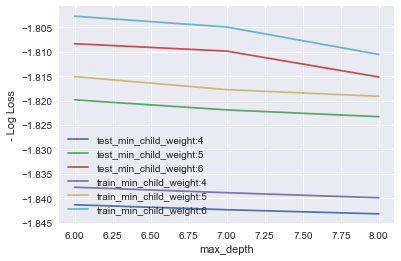

In [8]:
# summarize results
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
test_means = gsearch2_2.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_2.cv_results_[ 'std_test_score' ]
train_means = gsearch2_2.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_2.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_2.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(min_child_weight), len(max_depth))
train_scores = np.array(train_means).reshape(len(min_child_weight), len(max_depth))

for i, value in enumerate(min_child_weight):
    pyplot.plot(max_depth, test_scores[i], label= 'test_min_child_weight:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( '- Log Loss' )
pyplot.savefig( 'max_depth_vs_min_child_weght2.png' )